In [11]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x
    
class InnerUNet(nn.Module):
    def __init__(self, in_channels, features): # (128, 32) but as per new H1 we want it to be (256, feat)  for now feat = 32
        #basically i/p here is [1,256,64,64]
        super(InnerUNet, self).__init__()
        self.down1 = Block(in_channels, features, down=True, act="leaky", use_dropout=False)      #d1 [1, 32, 32, 32]
        self.down2 = Block(features , features * 2, down=True, act="leaky", use_dropout=False)    #d2 [1, 64, 16, 16]
        self.down3 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False) #d3 [1, 128, 8,  8]
        self.down4 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False) #d4 [1, 256, 4,  4]

        self.bottleneck = nn.Sequential(                                                               #d5 [1, 512, 2,  2]
            nn.Conv2d(features * 8, features * 16, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 4, down=False, act="relu", use_dropout=False)   #u1 [1, 128,  8,  8] 
        self.up2 = Block((features * 4) + (features * 4), features * 2, down=False, act="relu", use_dropout=False)   #u2 [1,  64, 16, 16]
        self.up3 = Block((features * 2)+ (features * 2), features, down=False, act="relu", use_dropout=False)       #u3 [1,  32, 32, 32]
        self.up4 = Block(features * 2 , features * 8, down=False, act="relu", use_dropout=False)          #u4 [1,  256, 64, 64]
        # self.final_up = nn.ConvTranspose2d(features, in_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        bottleneck = self.bottleneck(d4)
        up1 = self.up1(d4)
        up2 = self.up2(torch.cat([up1, d3], dim=1))
        up3 = self.up3(torch.cat([up2, d2], dim=1))
        up4 = self.up3(torch.cat([up3, d1], dim=1))
        
        return bottleneck, up2, up4, d4

class OuterUNet(nn.Module):
    def __init__(self, in_channels, features): # Assumming [bs, 3,512,512] input and features == 64
        super(OuterUNet, self).__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )                                                                                         #d0 [1,  64, 256,256]
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)     #d1 [1, 128, 128,128]
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False) #d2 [1, 256, 64, 64]
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False) #d3 [1, 512, 32, 32]
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False) #d4 [1, 512, 16, 16]
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False) #d5 [1, 512, 8, 8]
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False) #d6 [1, 512, 4, 4]
        self.down7 = nn.Sequential(                                                               #d7 [1, 512, 2, 2]  
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU() 
        )
    
        self.inner_unet = InnerUNet(features * 4, features // 2) # (128, 32) but as per new H1 we want it to be (256, 32)
        
        self.up1 = Block((features * 8)+(features * 8) , features * 8, down=False, act="relu", use_dropout=True)       #u1 [1, 512, 4, 4]
        self.up2 = Block((features * 8) + (features * 4), features * 8, down=False, act="relu", use_dropout=True)     #u2 [1, 512, 8 ,8] 
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)    #u3 [1,  512,16 ,16]
        self.up4 = Block((features * 8) + (features), features * 8, down=False, act="relu", use_dropout=False)   #u4 [1,  512, 32 ,32] 
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)   #u5 [1,  256, 64 ,64]
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)   #u6 [1,  128, 128 ,128]
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)       #u7 [1,   64, 256 ,256]

        self.final_up = nn.Sequential(                                                         #Final o/p [1, 3, 512, 512]
            nn.ConvTranspose2d(features , in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),                                                                                                                                                          
        )

    def forward(self, x):
        d0 = self.initial_down(x)
        d1 = self.down1(d0)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)

        # Inner U-Net connections
        bottleneck_inner , up2_inner, up4_inner, d4_inner = self.inner_unet(d2)

        # Outer U-Net continues from bottleneck with inner-outer concatenations
        up1 = self.up1(torch.cat([d7, bottleneck_inner], dim=1))
        up2 = self.up2(torch.cat([d4_inner ,up1], dim=1))
        up3 = self.up3(torch.cat([up2, d5], dim=1))
        up4 = self.up4(torch.cat([up2_inner, up3], dim=1))
        up5 = self.up5(torch.cat([up4, d3], dim=1))
        up6 = self.up6(torch.cat([up4_inner, up5], dim=1))
        up7 = self.up7(torch.cat([up6, d1], dim=1))
        final_up = self.final_up(up7)
        return final_up

def test_model():
    x = torch.randn((1, 3, 512, 512))  
    model = OuterUNet(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)

test_model()

RuntimeError: Given transposed=1, weight of size [128, 32, 4, 4], expected input[1, 64, 32, 32] to have 128 channels, but got 64 channels instead

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input image shape: torch.Size([1, 3, 128, 128])
Final output image shape (512x512): torch.Size([1, 3, 512, 512])


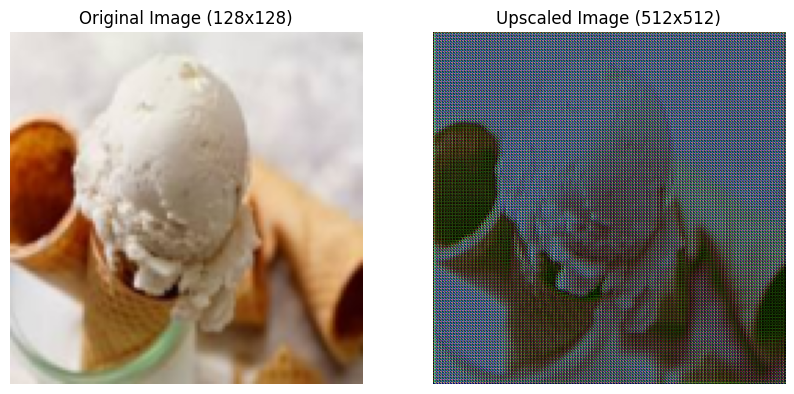

Parameters in first block: 150
Parameters in second block: 150
Total parameters: 300


In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the Block class with upsampling
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),  # No output padding here
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

# Function to load and resize the image
def load_and_resize_image(image_path, size=(128, 128)):
    image = Image.open(image_path).convert("RGB")  # Load image and convert to RGB
    transform = transforms.Compose([
        transforms.Resize(size),          # Resize the image to 128x128
        transforms.ToTensor()            # Convert the image to a tensor
    ])
    return transform(image).unsqueeze(0)  # Add a batch dimension

# Function to upscale the image
def upscale_image(input_image):
    # Create instances of the Block class for two upscalings
    upscale_block1 = Block(3, out_channels=3, down=False)  # Upscaling to 256x256
    upscale_block2 = Block(3, out_channels=3, down=False)  # Upscaling to 512x512

    # Apply the first upscaling block
    intermediate_image = upscale_block1(input_image)
    
    # Apply the second upscaling block
    output_image = upscale_block2(intermediate_image)
    
    return output_image

# Function to plot images
def plot_images(original, upscaled):
    # Convert tensors to numpy arrays for plotting
    original = original.squeeze(0).permute(1, 2, 0).numpy()
    upscaled = upscaled.squeeze(0).permute(1, 2, 0).detach().numpy()

    # Plot the images
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image (128x128)")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Upscaled Image (512x512)")
    plt.imshow(upscaled)
    plt.axis("off")

    plt.show()

# Main function to run the process
def main(image_path):
    # Load and resize the image
    input_image = load_and_resize_image(image_path)

    # Print the shape of the input image
    print("Input image shape:", input_image.shape)

    # Upscale the image
    output_image = upscale_image(input_image)

    # Print the shape of the output image
    print("Final output image shape (512x512):", output_image.shape)

    # Plot the original and upscaled images
    plot_images(input_image, output_image)

# Run the main function with your image path
image_path = "icecream.jpeg"  # Replace with your image path
main(image_path)

# Function to calculate the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create instances of the Block class for upscaling
upscale_block1 = Block(3, out_channels=3, down=False)
upscale_block2 = Block(3, out_channels=3, down=False)

# Count the parameters
params_block1 = count_parameters(upscale_block1)
params_block2 = count_parameters(upscale_block2)

print(f"Parameters in first block: {params_block1}")
print(f"Parameters in second block: {params_block2}")
print(f"Total parameters: {params_block1 + params_block2}")


In [ ]:
# import torch
# import torch.nn as nn

# class Block(nn.Module):
#     def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
#         super(Block, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
#             if down
#             else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
#         )
#         self.use_dropout = use_dropout
#         self.dropout = nn.Dropout(0.5)
#         self.down = down

#     def forward(self, x):
#         x = self.conv(x)
#         return self.dropout(x) if self.use_dropout else x

# class InnerUNet(nn.Module):
#     def __init__(self, in_channels, features):
#         super(InnerUNet, self).__init__()
#         self.down1 = Block(in_channels, features * 4, down=True, act="leaky", use_dropout=False)
#         self.down2 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
#         self.down3 = Block(features * 8, features * 16, down=True, act="leaky", use_dropout=False)
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(features * 16, features * 32, 4, 2, 1), nn.ReLU()
#         )
#         self.up1 = Block(features * 32, features * 16, down=False, act="relu", use_dropout=False)
#         self.up2 = Block(features * 16, features * 8, down=False, act="relu", use_dropout=False)
#         self.up3 = Block(features * 8, features * 4, down=False, act="relu", use_dropout=False)
#         self.final_up = nn.ConvTranspose2d(features * 4, in_channels, kernel_size=4, stride=2, padding=1)

#     def forward(self, x):
#         d1 = self.down1(x)
#         d2 = self.down2(d1)
#         d3 = self.down3(d2)
#         bottleneck = self.bottleneck(d3)
#         up1 = self.up1(bottleneck)
#         up2 = self.up2(torch.cat([up1, d3], dim=1))
#         up3 = self.up3(torch.cat([up2, d2], dim=1))
#         final_output = self.final_up(torch.cat([up3, d1], dim=1))  
        
#         return bottleneck, up1, up2, up3, final_output

# class OuterUNet(nn.Module):
#     def __init__(self, in_channels, features):
#         super(OuterUNet, self).__init__()
#         self.initial_down = nn.Sequential(
#             nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
#             nn.LeakyReLU(0.2),
#         )
#         self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
#         self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)
#         self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
#         self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
#         self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
#         self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)

#         self.inner_unet = InnerUNet(features * 2, features // 2)  # Inner U-Net starts here

#         self.bottleneck_outer = nn.Sequential(
#             nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
#         )

#         self.up1 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
#         self.up2 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
#         self.up3 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)
#         self.up4 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)
#         self.up5 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
#         self.final_up = nn.Sequential(
#             nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
#             nn.Tanh(),
#         )

#     def forward(self, x):
#         d1 = self.initial_down(x)
#         d2 = self.down1(d1)
#         d3 = self.down2(d2)
#         d4 = self.down3(d3)
#         d5 = self.down4(d4)
#         d6 = self.down5(d5)
#         d7 = self.down6(d6)

#         # Inner U-Net connections
#         bottleneck_inner, up1_inner, up2_inner, up3_inner, final_output_inner = self.inner_unet(d1)

#         # Outer U-Net continues from bottleneck with inner-outer concatenations
#         bottleneck_outer = self.bottleneck_outer(d7)
#         up1 = self.up1(torch.cat([bottleneck_outer, bottleneck_inner, d7], dim=1))
#         up2 = self.up2(torch.cat([up1_inner ,up1, d6], dim=1))
#         up3 = self.up3(torch.cat([up2, d5], dim=1))
#         up4 = self.up4(torch.cat([up2_inner, up3, d4], dim=1))
#         up5 = self.up5(torch.cat([up4, d3], dim=1))
#         up6 = self.final_up(torch.cat([up3_inner, up5, d2], dim=1))
#         return up6

# def test_model():
#     x = torch.randn((1, 3, 256, 256))  
#     model = OuterUNet(in_channels=3, features=64)
#     preds = model(x)
#     print(preds.shape)

# test_model()

In [10]:
import torch

# Assuming two input tensors of shape [1, 32, 32, 32]
x1 = torch.randn(1, 32, 32, 32)
x2 = torch.randn(1, 32, 32, 32)

# Concatenate them along the channel dimension
x_concat = torch.cat([x1, x2], dim=1)  # Resulting shape: [1, 64, 32, 32]

# Define the Block
block = Block(in_channels=64, out_channels=256, down=False)

# Forward pass
output = block(x_concat)  # Output shape: [1, 256, 64, 64]
print(output.shape)  # Should print torch.Size([1, 256, 64, 64])


torch.Size([1, 256, 64, 64])
